# Chord Progressions Similarity based on 'A music similarity measure based on chord progression and song segmentation analysis'

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import operator

# Data

## 데이터셋 불러오기

In [ ]:
# df_commu: ComMu 논문 데이터셋
df_commu = pd.read_csv("/content/drive/MyDrive/DSL/2022-2/[POZAlabs] 기업연계 프로젝트/ComMU-code/dataset/commu_meta.csv", index_col=0)
df_commu

,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id
0,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001
1,cmajor,"[['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Dm'...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002
2,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003
3,cmajor,"[['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Gm'...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004
4,aminor,"[['Am', 'Am', 'Am', 'Am', 'Em', 'Em', 'Em', 'E...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,cmajor,"[['Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7',...",mid_high,8,110,cinematic,pad,synth_pad,standard,4/4,83,84,val,commu11140
11140,cmajor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid_low,8,110,cinematic,riff,acoustic_guitar,standard,4/4,51,55,val,commu11141
11141,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",very_low,8,145,cinematic,bass,string_ensemble,standard,4/4,109,112,val,commu11142
11142,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",low,8,140,cinematic,accompaniment,string_cello,standard,4/4,55,115,val,commu11143


## df_commu 전처리

### chord_progression 리스트로 변환

In [ ]:
# df_commu['chord_progressions']: str -> list
def chord_progressions_preprocessing(x):
  return x.replace("'", "")[2:-2].split(', ') 

In [ ]:
df_commu['chord_progressions'] = df_commu.chord_progressions.apply(chord_progressions_preprocessing)

In [ ]:
# 확인
df_commu['chord_progressions']

0        [Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, C...
1        [C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, D...
2        [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
3        [C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, G...
4        [Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, F...
                               ...                        
11139    [Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fma...
11140    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11141    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11142    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11143    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
Name: chord_progressions, Length: 11144, dtype: object

In [ ]:
df_commu.head()

,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id
0,aminor,"[Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, C...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001
1,cmajor,"[C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, D...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002
2,aminor,"[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003
3,cmajor,"[C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, G...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004
4,aminor,"[Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, F...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005


### train/val split

In [ ]:
# train / val split
df_train = df_commu[df_commu["split_data"] == "train"]
df_val = df_commu[df_commu["split_data"] == "val"]

In [ ]:
# 확인
train_num = df_train.shape[0]
val_num = df_val.shape[0]
print("train:", train_num, "| test:", val_num, "| total:", train_num + val_num)

train: 10381 | test: 763 | total: 11144


## df_c_sim 전처리

In [ ]:
# df_c: 각 코드별 구성음 (본 노트북에서 사용되지는 않음. 어떻게 임베딩했는지 예시용으로만 참고)
df_c = pd.read_csv("/content/drive/MyDrive/DSL/2022-2/[POZAlabs] 기업연계 프로젝트/piano_chord.csv")
df_c

,major,chord,major_chord,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
0,C,,C,1,0,0,0,1,0,0,1,0,0,0,0
1,C,m,Cm,1,0,0,1,0,0,0,1,0,0,0,0
2,C,7,C7,1,0,0,0,1,0,0,1,0,0,1,0
3,C,m7,Cm7,1,0,0,1,0,0,0,1,0,0,1,0
4,C,maj7,Cmaj7,1,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,B,dim,Bdim,0,0,1,0,0,1,0,0,0,0,0,1
332,B,dim7,Bdim7,0,0,1,0,0,1,0,0,1,0,0,1
333,B,m7b5,Bm7b5,0,0,1,0,0,1,0,0,0,1,0,1
334,B,+,B+,0,0,0,1,0,0,0,1,0,0,0,1


In [ ]:
# df_c_sim: 코드간 유사도
df_c_sim = pd.read_csv("/content/drive/MyDrive/DSL/2022-2/[POZAlabs] 기업연계 프로젝트/Chord_similarity_revised_ver_1.csv", index_col=0)
df_c_sim

,major_chord,Cb,Cbm,Cb7,Cbm7,Cbmaj7,CbmM7,Cb6,Cbm6,Cbadd2,...,B#m6,B#add2,B#madd2,B#sus4,B#sus2,B#dim,B#dim7,B#m7b5,B#+,B#7sus4
0,Cb,1.00,0.500,0.750,0.400,0.750,0.400,0.750,0.400,0.750,...,0.167,0.000,0.167,0.000,0.000,0.500,0.400,0.400,0.000,0.000
1,Cbm,0.50,1.000,0.400,0.750,0.400,0.750,0.400,0.750,0.400,...,0.000,0.167,0.167,0.000,0.200,0.200,0.167,0.167,0.000,0.000
2,Cb7,0.75,0.400,1.000,0.600,0.600,0.333,0.600,0.333,0.600,...,0.333,0.000,0.143,0.000,0.000,0.400,0.600,0.333,0.000,0.000
3,Cbm7,0.40,0.750,0.600,1.000,0.333,0.600,0.333,0.600,0.333,...,0.143,0.143,0.143,0.000,0.167,0.167,0.333,0.143,0.000,0.000
4,Cbmaj7,0.75,0.400,0.600,0.333,1.000,0.600,0.600,0.333,0.600,...,0.143,0.000,0.143,0.000,0.000,0.400,0.333,0.600,0.000,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,B#dim,0.50,0.200,0.400,0.167,0.400,0.167,0.400,0.167,0.400,...,0.400,0.167,0.400,0.200,0.200,1.000,0.750,0.750,0.200,0.167
353,B#dim7,0.40,0.167,0.600,0.333,0.333,0.143,0.333,0.143,0.333,...,0.600,0.143,0.333,0.167,0.167,0.750,1.000,0.600,0.167,0.143
354,B#m7b5,0.40,0.167,0.333,0.143,0.600,0.333,0.333,0.143,0.333,...,0.333,0.143,0.333,0.167,0.167,0.750,0.600,1.000,0.167,0.333
355,B#+,0.00,0.000,0.000,0.000,0.000,0.000,0.167,0.167,0.000,...,0.167,0.400,0.167,0.200,0.200,0.200,0.167,0.167,1.000,0.167


In [ ]:
# major_chord -> index로
df_c_sim = df_c_sim.set_index("major_chord")

In [ ]:
# 확인
df_c_sim

,Cb,Cbm,Cb7,Cbm7,Cbmaj7,CbmM7,Cb6,Cbm6,Cbadd2,Cbmadd2,...,B#m6,B#add2,B#madd2,B#sus4,B#sus2,B#dim,B#dim7,B#m7b5,B#+,B#7sus4
major_chord,,,,,,,,,,,,,,,,,,,,,
Cb,1.00,0.500,0.750,0.400,0.750,0.400,0.750,0.400,0.750,0.400,...,0.167,0.000,0.167,0.000,0.000,0.500,0.400,0.400,0.000,0.000
Cbm,0.50,1.000,0.400,0.750,0.400,0.750,0.400,0.750,0.400,0.750,...,0.000,0.167,0.167,0.000,0.200,0.200,0.167,0.167,0.000,0.000
Cb7,0.75,0.400,1.000,0.600,0.600,0.333,0.600,0.333,0.600,0.333,...,0.333,0.000,0.143,0.000,0.000,0.400,0.600,0.333,0.000,0.000
Cbm7,0.40,0.750,0.600,1.000,0.333,0.600,0.333,0.600,0.333,0.600,...,0.143,0.143,0.143,0.000,0.167,0.167,0.333,0.143,0.000,0.000
Cbmaj7,0.75,0.400,0.600,0.333,1.000,0.600,0.600,0.333,0.600,0.333,...,0.143,0.000,0.143,0.000,0.000,0.400,0.333,0.600,0.000,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B#dim,0.50,0.200,0.400,0.167,0.400,0.167,0.400,0.167,0.400,0.167,...,0.400,0.167,0.400,0.200,0.200,1.000,0.750,0.750,0.200,0.167
B#dim7,0.40,0.167,0.600,0.333,0.333,0.143,0.333,0.143,0.333,0.143,...,0.600,0.143,0.333,0.167,0.167,0.750,1.000,0.600,0.167,0.143
B#m7b5,0.40,0.167,0.333,0.143,0.600,0.333,0.333,0.143,0.333,0.143,...,0.333,0.143,0.333,0.167,0.167,0.750,0.600,1.000,0.167,0.333


# Similarity Function

## Aminor -> Cminor 함수 정의
- Cminor & Cmajor간 비교를 위함

In [ ]:
# Aminor -> Cminor
atoc_dict = {'Cb':'D', 'C':'D#', 'C#':'E',
             'Db':'E', 'D':'F', 'D#':'F#',
             'Eb':'F#', 'E':'G', 'E#':'G#',
             'Fb':'G', 'F':'G#', 'F#':'A',
             'Gb':'A', 'G':'A#', 'G#':'B',
             'Ab':'B', 'A':'C', 'A#':'C#',
             'Bb':'C#', 'B':'D', 'B#':'D#'}

def amTocm(s):
  new_s = s.copy()
  for i, c in enumerate(new_s):
    if len(c) == 1:
      new_s[i] = atoc_dict[c]
    else:
      if c[1] in ('b', '#'):
        new_s[i] = atoc_dict[c[:2]]+c[2:]
      else:
        new_s[i] = atoc_dict[c[:1]]+c[1:]
  return new_s

## similarity 함수 정의

In [ ]:
def sequence_sim(n1, n2, n_unit, output):   # n1, n2: id
                                            # n_unit: 유사도 검사 단위 (마디수)
                                            # 참고: index = id - 1
                                            # output: 결과 출력 여부
    
    ### 1. 전제 조건
    # time_signature가 같은 sequence만 비교할 것
    if (df_commu.loc[n1 - 1, "time_signature"] == df_commu.loc[n2 - 1, "time_signature"]):
        print("time_signature: {0} 인 두 sequence의 유사도를 계산합니다.\n".format(df_commu.loc[n1 - 1, "time_signature"]))
    else:
        if output == True:
            print("time_signature가 같은 sequence만 비교할 수 있습니다.")
        return None

    # 혹시 두 sequence의 audio_key가 다르신가요?
    n1_chord_progressions = df_commu.loc[n1 - 1, 'chord_progressions']
    n2_chord_progressions = df_commu.loc[n2 - 1, 'chord_progressions']

    if (df_commu.loc[n1 - 1, 'audio_key'] != df_commu.loc[n2 - 1, 'audio_key']):
        if df_commu.loc[n1 - 1, 'audio_key'] == 'aminor':
            n1_chord_progressions = amTocm(df_commu.loc[n1 - 1, 'chord_progressions'])
            print("id {0}의 audio_key는 aminor, id {1}의 audio_key는 cmajor 입니다.\n유사도 계산을 위해 id {2}의 audio_key를 cminor로 변경합니다.\n".format(n1, n2, n1))
        else:
            n2_chord_progressions = amTocm(df_commu.loc[n2 - 1, 'chord_progressions'])
            print("id {0}의 audio_key는 cmajor, id {1}의 audio_key는 aminor 입니다.\n유사도 계산을 위해 id {2}의 audio_key를 cminor로 변경합니다.\n".format(n1, n2, n2))
    else:
        print("두 sequence의 audio_key가 동일합니다.\n")
    
    # 혹시 못갖춘마디이신가요?
    if (df_commu.loc[n1 - 1, "num_measures"] % 2 != 0) & (df_commu.loc[n2 - 1, "num_measures"] % 2 != 0):
        print("id {0}와 {1} sequence은 못갖춘마디를 포함하고 있습니다.\n".format(n1, n2))
    elif df_commu.loc[n1 - 1, "num_measures"] % 2 != 0:
        print("id {0} sequence은 못갖춘마디를 포함하고 있습니다.\n".format(n1))
    elif df_commu.loc[n2 - 1, "num_measures"] % 2 != 0:
        print("id {0} sequence은 못갖춘마디를 포함하고 있습니다.\n".format(n2))
    else:
        print("두 sequence 모두 갖춘마디입니다.\n")



    ### 2. 변수 설정
    s1 = n1_chord_progressions
    s2 = n2_chord_progressions

    # 길이가 더 긴 chord sequence는 길이가 m인 array arr_a로 표현, 다른건 길이가 n인 array arr_b로 표현
    # 참고: len(chord_progression) == num_measures * 8
    if len(s1) >= len(s2):      # s1의 길이가 더 긴 경우
        m = len(s1)
        arr_a = np.array(s1)
        n = len(s2)
        arr_b = np.array(s2)
    else:                       # s2의 길이가 더 긴 경우
        m = len(s2)
        arr_a = np.array(s2)
        n = len(s1)
        arr_b = np.array(s1)

    # time_signature 확인 후 n_per 설정
    # n_per: 한 마디 안에 8분음표가 n_per개 만큼 있음
    if df_commu.loc[n1 - 1, "time_signature"] == "4/4":
        n_per = 8
    else:
        n_per = 6

    # n_unit * n_per은 두 sequence 중 짧은 것의 길이 이하여야 함
    if n_unit * n_per > n:
        n_unit = n // n_per


    
    ### 3. 유사도 계산
    n_unit = n_unit * n_per                # n_unit: 유사도 검사 단위 (마디수 * n_per)
    cs_sim = 0
    critical_point = {"arr_a" : 1, "arr_b" : 1}

    sim_matrix = [[0 for _ in range(int((m-n_unit) / n_per) + 1)] for _ in range(int((n-n_unit) / n_per) + 1)] # sim_matrix: 유사도 계산 결과를 담을 이중 리스트

    for i in range(0, m-n_unit+1, n_per):      # i: arr_a의 마디 시작점
        for j in range(0, n-n_unit+1, n_per):  # j: arr_b의 마디 시작점
            
            sim = 0
            for k in range(n_unit):        # n_unit만큼을 한 마디씩 옮겨가며 similarity 계산 
                sim += df_c_sim.loc[arr_a[i+k], arr_b[j+k]]
            sim = sim / n_unit
            sim_matrix[math.floor(j/n_per)][math.floor(i/n_per)] = sim
            
            if sim > cs_sim:               # cs_sim 갱신
                cs_sim = sim    
                critical_point["arr_a"] = int(i/n_per+1)
                critical_point["arr_b"] = int(j/n_per+1)

    
    ### 4. 유사도 계산 결과 출력
    if output == True:
        
        # 최종 유사도
        # 못갖춘마디를 포함한 곡들은 마디 번호를 하나씩 미뤄서 출력해야함
        if (df_commu.loc[n1 - 1, "num_measures"] % 2 != 0) & (df_commu.loc[n2 - 1, "num_measures"] % 2 != 0):
            print("S1과 S2에서 가장 유사한 부분은 S1의 {0}번째 마디부터 {1}마디와 S2의 {2}번째 마디부터 {1}마디이며, 유사도는 {3}입니다.\n".format(critical_point["arr_a"]+1, int(n_unit/n_per), critical_point["arr_b"]+1, round(cs_sim, 4)))
            print("- S1의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_a"]+1, int(n_unit/n_per), arr_a[(critical_point["arr_a"]-1)*n_per: (critical_point["arr_a"]-1)*n_per + n_unit]))
            print("- S2의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_b"]+1, int(n_unit/n_per), arr_b[(critical_point["arr_b"]-1)*n_per: (critical_point["arr_b"]-1)*n_per + n_unit]))
        elif df_commu.loc[n1 - 1, "num_measures"] % 2 != 0:
            print("S1과 S2에서 가장 유사한 부분은 S1의 {0}번째 마디부터 {1}마디와 S2의 {2}번째 마디부터 {1}마디이며, 유사도는 {3}입니다.\n".format(critical_point["arr_a"]+1, int(n_unit/n_per), critical_point["arr_b"], round(cs_sim, 4)))
            print("- S1의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_a"]+1, int(n_unit/n_per), arr_a[(critical_point["arr_a"]-1)*n_per: (critical_point["arr_a"]-1)*n_per + n_unit]))
            print("- S2의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_b"], int(n_unit/n_per), arr_b[(critical_point["arr_b"]-1)*n_per: (critical_point["arr_b"]-1)*n_per + n_unit]))
        elif df_commu.loc[n2 - 1, "num_measures"] % 2 != 0:
            print("S1과 S2에서 가장 유사한 부분은 S1의 {0}번째 마디부터 {1}마디와 S2의 {2}번째 마디부터 {1}마디이며, 유사도는 {3}입니다.\n".format(critical_point["arr_a"], int(n_unit/n_per), critical_point["arr_b"]+1, round(cs_sim, 4)))
            print("- S1의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_a"], int(n_unit/n_per), arr_a[(critical_point["arr_a"]-1)*n_per: (critical_point["arr_a"]-1)*n_per + n_unit]))
            print("- S2의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_b"]+1, int(n_unit/n_per), arr_b[(critical_point["arr_b"]-1)*n_per: (critical_point["arr_b"]-1)*n_per + n_unit]))
        else:
            print("S1과 S2에서 가장 유사한 부분은 S1의 {0}번째 마디부터 {1}마디와 S2의 {2}번째 마디부터 {1}마디이며, 유사도는 {3}입니다.\n".format(critical_point["arr_a"], int(n_unit/n_per), critical_point["arr_b"], round(cs_sim, 4)))
            print("- S1의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_a"], int(n_unit/n_per), arr_a[(critical_point["arr_a"]-1)*n_per: (critical_point["arr_a"]-1)*n_per + n_unit]))
            print("- S2의 {0}번째 마디부터 {1}마디:\n  {2}\n".format(critical_point["arr_b"], int(n_unit/n_per), arr_b[(critical_point["arr_b"]-1)*n_per: (critical_point["arr_b"]-1)*n_per + n_unit]))
        
        # 전체 유사도 플롯
        plt.figure(figsize=(5,5))
        plt.xlabel("S1", size = 12)                             # x축, y축 레이블 추가
        plt.ylabel("S2", size = 12)
        plt.title("Similarity between S1 and S2", size = 15)    # 플롯 제목 추가
        plt.imshow(sim_matrix, cmap="coolwarm")                 # 출력
        plt.show()

    return cs_sim

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

S1과 S2에서 가장 유사한 부분은 S1의 4번째 마디부터 4마디와 S2의 1번째 마디부터 4마디이며, 유사도는 0.8375입니다.

- S1의 4번째 마디부터 4마디:
  ['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'F' 'F' 'F' 'F' 'G' 'G' 'G' 'Am' 'Am'
 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Gsus4' 'Gsus4' 'Gsus4' 'Gsus4'
 'Gsus4' 'Gsus4' 'Gsus4' 'Gsus4']

- S2의 1번째 마디부터 4마디:
  ['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm'
 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Gsus4' 'Gsus4' 'Gsus4' 'Gsus4'
 'Gsus4' 'Gsus4' 'Gsus4' 'Gsus4']



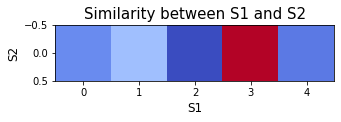

0.8374999999999999


In [ ]:
# 확인: 정상 작동
print(sequence_sim(9845, 61, 8, True))

time_signature: 3/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

id 2535 sequence은 못갖춘마디를 포함하고 있습니다.

S1과 S2에서 가장 유사한 부분은 S1의 7번째 마디부터 4마디와 S2의 8번째 마디부터 4마디이며, 유사도는 0.875입니다.

- S1의 7번째 마디부터 4마디:
  ['C' 'C' 'C' 'C' 'C' 'C' 'Dm7' 'Dm7' 'Dm7' 'Dm7' 'Dm7' 'Dm7' 'G7' 'G7'
 'G7' 'G7' 'G7' 'G7' 'C' 'C' 'C' 'C' 'C' 'C']

- S2의 8번째 마디부터 4마디:
  ['Cmaj7' 'Cmaj7' 'Cmaj7' 'Cmaj7' 'Cmaj7' 'Cmaj7' 'Dm7' 'Dm7' 'Dm7' 'Dm7'
 'Dm7' 'Dm7' 'G7' 'G7' 'G7' 'G7' 'G7' 'G7' 'Cmaj7' 'Cmaj7' 'Cmaj7' 'Cmaj7'
 'Cmaj7' 'Cmaj7']



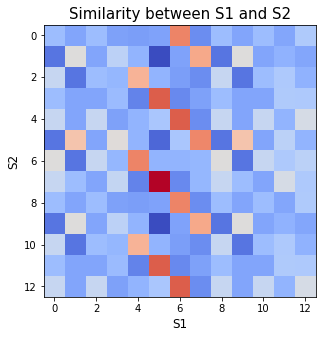

0.875


In [ ]:
# 확인: 정상 작동 (못갖춘마디, 3/4박)
print(sequence_sim(2535, 2077, 4, True))

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

id 1의 audio_key는 aminor, id 2의 audio_key는 cmajor 입니다.
유사도 계산을 위해 id 1의 audio_key를 cminor로 변경합니다.

두 sequence 모두 갖춘마디입니다.

S1과 S2에서 가장 유사한 부분은 S1의 1번째 마디부터 8마디와 S2의 1번째 마디부터 8마디이며, 유사도는 0.2125입니다.

- S1의 1번째 마디부터 8마디:
  ['Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'D#' 'D#' 'D#' 'D#' 'D#' 'D#'
 'D#' 'D#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'Fm' 'Fm' 'Fm' 'Fm'
 'Fm' 'Fm' 'Fm' 'Fm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'Cm' 'D#' 'D#'
 'D#' 'D#' 'D#' 'D#' 'D#' 'D#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'A#' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F']

- S2의 1번째 마디부터 8마디:
  ['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm' 'Dm'
 'G7' 'G7' 'G7' 'G7' 'G7' 'G7' 'G7' 'G7' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'Am' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']



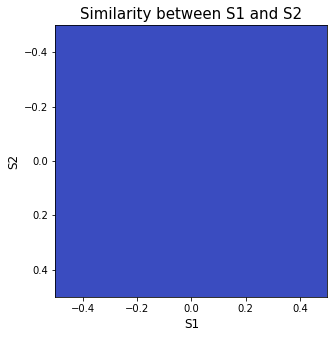

0.21249999999999974

In [ ]:
# 확인: 정상 작동 (audio_key가 다른 경우)
sequence_sim(1, 2, 8, True)

In [ ]:
# 확인: 전제 조건 만족 못한 경우
sequence_sim(1, 2067, 8, True)

time_signature가 같은 sequence만 비교할 수 있습니다.


# 공통 Sample 비교

## sample 1. 상이한 조건에서 뽑은 sample 비교

In [ ]:
sample1_list = [(0, 6), (35, 11099), (9346, 9365),
                (9353, 9364), (1416, 1467), (3, 17),
                (1, 23), (4859, 4906), (1412, 1417)]
sample1_dict = {}

In [ ]:
for (n1, n2) in sample1_list:
    sample1_dict[(n1, n2)] = round(sequence_sim(n1+1, n2+1, 4, False), 2)

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 3/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 6/8 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 6/8 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 3/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 6/8 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.



In [ ]:
sample1_dict

{(0, 6): 0.5,
 (35, 11099): 0.48,
 (9346, 9365): 0.83,
 (9353, 9364): 0.76,
 (1416, 1467): 0.73,
 (3, 17): 0.55,
 (1, 23): 1.0,
 (4859, 4906): 0.25,
 (1412, 1417): 0.55}

## sample 2. 동일한 조건에서 뽑은 sample 비교
- audio_key: cmajor
- time_signature: 4/4
- bpm_group: slow
- num_measures: 8

In [ ]:
sample2_list = [   1,   40,   41,   42,   45,   53,   55,   57,   86,  117,  131,
             164,  175,  189,  193,  256,  284,  287,  291,  457,  705,  725,
             737,  739,  751,  798, 1040, 1481, 1487, 1750, 2464, 2562, 2811,
            2855, 2919, 3401, 4742, 4757, 4890, 7275, 7956, 7957, 7972, 7974,
            7980, 7994, 8140, 8179, 8684, 9179, 9291, 9381, 9400, 9465, 9976]
sample2_dict = {}

In [ ]:
for index in sample2_list:
    sample2_dict[index] = round(sequence_sim(2, index + 1, 4, False), 2)

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 sequence 모두 갖춘마디입니다.

time_signature: 4/4 인 두 sequence의 유사도를 계산합니다.

두 sequence의 audio_key가 동일합니다.

두 se

In [ ]:
sample2_dict = sorted(sample2_dict.items(), key=operator.itemgetter(1))
sample2_dict

[(9976, 0.32),
 (41, 0.45),
 (1750, 0.47),
 (7972, 0.47),
 (9179, 0.5),
 (40, 0.51),
 (86, 0.51),
 (256, 0.51),
 (2919, 0.51),
 (4757, 0.52),
 (2811, 0.54),
 (8140, 0.54),
 (9291, 0.56),
 (189, 0.58),
 (2855, 0.58),
 (7980, 0.58),
 (9381, 0.58),
 (1481, 0.59),
 (2562, 0.59),
 (7974, 0.59),
 (53, 0.6),
 (164, 0.6),
 (193, 0.6),
 (284, 0.6),
 (3401, 0.6),
 (8179, 0.6),
 (8684, 0.6),
 (9400, 0.6),
 (725, 0.61),
 (737, 0.61),
 (751, 0.61),
 (131, 0.62),
 (4742, 0.65),
 (175, 0.67),
 (291, 0.67),
 (798, 0.67),
 (1040, 0.67),
 (117, 0.68),
 (287, 0.69),
 (1487, 0.69),
 (7957, 0.7),
 (9465, 0.7),
 (2464, 0.71),
 (42, 0.75),
 (55, 0.75),
 (7994, 0.75),
 (7956, 0.79),
 (457, 0.8),
 (705, 0.8),
 (57, 0.81),
 (7275, 0.81),
 (4890, 0.85),
 (739, 0.9),
 (1, 1.0),
 (45, 1.0)]